In [4]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

As an example we will take the minimization of a quadratic function from the Tensorflow Probability page.

In [5]:
# A high-dimensional quadratic bowl.
ndims = 60
minimum = np.ones([ndims], dtype='float64')
scales = np.arange(ndims, dtype='float64') + 1.0

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
    return tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(
        scales * tf.math.squared_difference(x, minimum), axis=-1),
        x)
start = np.arange(ndims, 0, -1, dtype='float64')
optim_results = tfp.optimizer.lbfgs_minimize(
    quadratic_loss_and_gradient,
    initial_position=start,
    num_correction_pairs=10,
    tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)

In [6]:
print(optim_results.position)

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(60,), dtype=float64)


Now we do a version with a loss function involving a tensorflow model

In [7]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/began/models/generator.h5")

In [70]:
z = np.random.randn(1, 64)
ma = gen.predict(z).astype(np.float32)

def L2(x):
    return tf.reduce_sum((gen.predict(x) - ma) ** 2)

In [42]:
def L2_loss_and_gradient(x):
    with tf.GradientTape() as t:
        t.watch(x)
        l2 = L2(x)
    return (l2, t.gradient(l2, x))

In [43]:
print(L2(z))
print(L2_loss_and_gradient(z))

ValueError: Error when checking input: expected Dense_G_input to have 2 dimensions, but got array with shape ()

(<tf.Tensor: id=72938, shape=(), dtype=float32, numpy=7320.0>,
 <tf.Tensor: id=72959, shape=(), dtype=float32, numpy=7320.0>)

In [33]:
optim_results = tfp.optimizer.lbfgs_minimize(L2_loss_and_gradient, np.random.randn(1, 64))

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [56]:
x = tf.ones((1, 64))

with tf.GradientTape() as tape:
    tape.watch(x)
    l2 = tf.reduce_sum((gen.predict(x) - ma) ** 2)
    print(l2)

# Derivative of z with respect to the original input tensor x
deriv = tape.gradient(l2, x)
for i in [0]:
    for j in [0, 1, 2, 3]:
        print(deriv[i][j].numpy())

tf.Tensor(1295.2013, shape=(), dtype=float32)


TypeError: 'NoneType' object is not subscriptable

In [75]:
def l2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss_value = tf.linalg.norm(gen(x) - ma)
    jac = tape.gradient(loss_value,x)
    loss_value = tf.reshape(loss_value, [1])
    return loss_value,jac

l2(tf.Variable(np.random.randn(1, 64)))

(<tf.Tensor: id=76696, shape=(1,), dtype=float32, numpy=array([33.022358], dtype=float32)>,
 <tf.Tensor: id=76694, shape=(1, 64), dtype=float64, numpy=
 array([[ -0.89289856,   1.32341576,  -2.99841976,   3.4519701 ,
          -0.31361657,   3.30504322,   4.34295177,   2.95539474,
          -0.60194403,   4.93278122,  -4.4894371 ,  -2.99535131,
          -5.74884558,   2.80302334,   2.53488255,   0.27077323,
           3.10876513,   0.09188875,  -3.03056192,  -4.40508842,
          -0.10247567,   2.09511042,  -1.19640851,  -6.44440556,
           7.17199039,   5.58401203,   0.32892159,  -0.51302135,
           4.07422543,   4.61970425,  -0.11202317,   1.7446295 ,
           3.44594526,  -1.08598506,   0.63064194,  -5.57563734,
           3.43859553,  -2.03553843,  -3.85138941,   3.49205637,
           4.65538216,   1.17041981,   8.19942474,  -0.02850474,
           6.19026566,  -3.30926323,  -1.76382256,   1.38544774,
          -2.17969513,  -0.01984363,   0.65391171,   1.02674162,
   

In [77]:
x = tf.Variable(np.random.randn(1, 64), dtype=np.float32)
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, tolerance=1e-03, max_iterations=200)

In [82]:
opt.position

<tf.Tensor: id=317276, shape=(1, 64), dtype=float32, numpy=
array([[ 0.21789679, -0.6313455 ,  0.51106536,  0.65428346, -0.08439946,
         0.15996875,  0.6932648 ,  1.1182942 , -0.0943156 ,  1.0689439 ,
        -0.04155379, -0.48364687,  0.09565908,  0.4104645 , -0.62831223,
        -0.42353338,  2.0371132 ,  0.39105245, -1.2190725 , -0.751586  ,
        -1.1491607 , -1.0210421 ,  0.4876957 , -0.66864806,  0.3402352 ,
         0.20590685,  0.8233872 ,  1.1527246 ,  0.32748926, -0.5523293 ,
         0.38691324,  0.47133523,  0.35015997,  0.58569425,  0.634142  ,
         0.02448684,  2.4783568 , -0.23769282, -0.15827827,  1.1713643 ,
         0.3895233 , -0.0509587 , -0.72352505,  1.2746007 , -0.96532923,
         0.19957016,  0.01229058, -1.0690758 ,  1.3527805 ,  0.8390821 ,
         0.48720038,  0.25274298,  0.00884889,  1.0221628 , -0.24245411,
        -2.4566364 ,  0.46026808, -0.32654712,  1.5195801 , -2.233098  ,
        -0.7562225 ,  0.73183864, -2.026973  , -0.8725368 ]],
  

In [83]:
z

array([[ 0.22102793, -0.6309637 ,  0.50750358,  0.65494294, -0.08698651,
         0.15995441,  0.69522444,  1.11722549, -0.09369051,  1.06821767,
        -0.04267474, -0.48162621,  0.09639111,  0.41031433, -0.6265107 ,
        -0.42128115,  2.03934224,  0.39020804, -1.2199234 , -0.75302536,
        -1.15165158, -1.02103217,  0.48577418, -0.6689901 ,  0.34021216,
         0.20728984,  0.82212041,  1.15275414,  0.32701924, -0.55215444,
         0.3837591 ,  0.46840364,  0.35116227,  0.58640549,  0.63425641,
         0.02432652,  2.48133161, -0.23711349, -0.15791156,  1.16778529,
         0.38941203, -0.05204195, -0.72209475,  1.27290658, -0.96879983,
         0.19759939,  0.015128  , -1.06853409,  1.35523778,  0.83933578,
         0.48488244,  0.25022723,  0.01242254,  1.0238608 , -0.24236905,
        -2.45703083,  0.46073581, -0.32543188,  1.51844582, -2.23321033,
        -0.75476463,  0.73202541, -2.02697527, -0.87485794]])

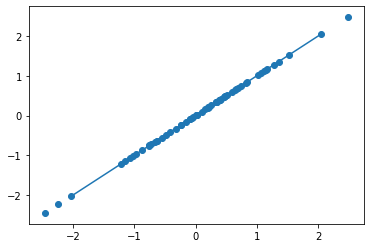

In [86]:
fig, ax = plt.subplots(1, 1)
ax.scatter(z, opt.position.numpy())
ax.plot(np.linspace(-2, 2), np.linspace(-2, 2))